# 07c scATAC MPPs Signac filtering

Determine which cells need to be filtered before overlaying MPP and HSC into LSKs

used this docker image

docker run 
--rm 
-d 
--name signac 
-p 8880:8888 
-e JUPYTER_ENABLE_LAB=YES 
-v /Users/efast/Documents/:/home/jovyan/work 
signac:0.2.5

In [1]:
library(Signac)
library(Seurat)
library(GenomeInfoDb)
library(EnsDb.Mmusculus.v79)
library(ggplot2)
library(JASPAR2018)
library(TFBSTools)
#library(BSgenome.Mmusculus.UCSC.mm10)
library(tidyverse)
library(data.table)
library(SummarizedExperiment)
library(GenomicRanges)
library(diffloop)
library(tidyverse)
library(diffloop)
library(SingleCellExperiment)

set.seed(1234)

Warning message:
“package ‘Seurat’ was built under R version 3.6.3”Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min

Loading required package: S4Vectors
Loading req

#### couldn't make the count matrix file within docker container - kernel kept crashing - did it in Rstudio (same comands as in 07a HSC notebook)

In [2]:
MPP_r <- readRDS("./sc_objects/scATAC_MPP_macs2.rds")

In [3]:
MPP_r

class: RangedSummarizedExperiment 
dim: 163902 10020 
metadata(0):
assays(1): counts
rownames: NULL
rowData names(2): id score
colnames(10020): AAACGAAAGAACGCCA-1 AAACGAAAGCTAGCAG-1 ...
  TTTGTGTTCCTCCATG-1 TTTGTGTTCTGTGTGA-1
colData names(3): sample depth FRIP

In [4]:
# need to specify the rownames
temp <- DataFrame(MPP_r@rowRanges)
rownames(MPP_r) <- temp$X

#read in metadata
metadata <- read.csv(
  file = "./raw_data/ATAC_MPP/singlecell.csv",
  header = TRUE,
  row.names = 1
)

#convert to SingleCellExperiment - Seurat compatible format
MPP <- as(MPP_r, "SingleCellExperiment")

#convert to SingleCellExperiment - Seurat compatible format
MPP <- as(MPP, "SingleCellExperiment")
MPP <- as.Seurat(MPP, counts = "counts", data = "counts")
MPP <- AddMetaData(object = MPP, metadata = metadata)
MPP@assays$peaks <- MPP@assays$RNA
DefaultAssay(MPP) <- 'peaks'

In [5]:
MPP

An object of class Seurat 
327804 features across 10020 samples within 2 assays 
Active assay: peaks (163902 features, 0 variable features)
 1 other assay present: RNA

In [6]:
fragment.path <- './raw_data/ATAC_MPP/fragments.tsv.gz'

MPP <- SetFragments(
  object = MPP,
  file = fragment.path
)

In [7]:
MPP <- NucleosomeSignal(object = MPP)

Extracting reads in requested region
Computing ratio of mononucleosomal to nucleosome-free fragments


In [8]:
# make column in metadata that denotes the nCounts in th count matrix

nCount_peaks = colSums(x = MPP, slot = "counts")
MPP$nCount_peaks = nCount_peaks

Warning message:
"Removed 3 rows containing non-finite values (stat_ydensity)."Warning message:
"Removed 3 rows containing missing values (geom_point)."

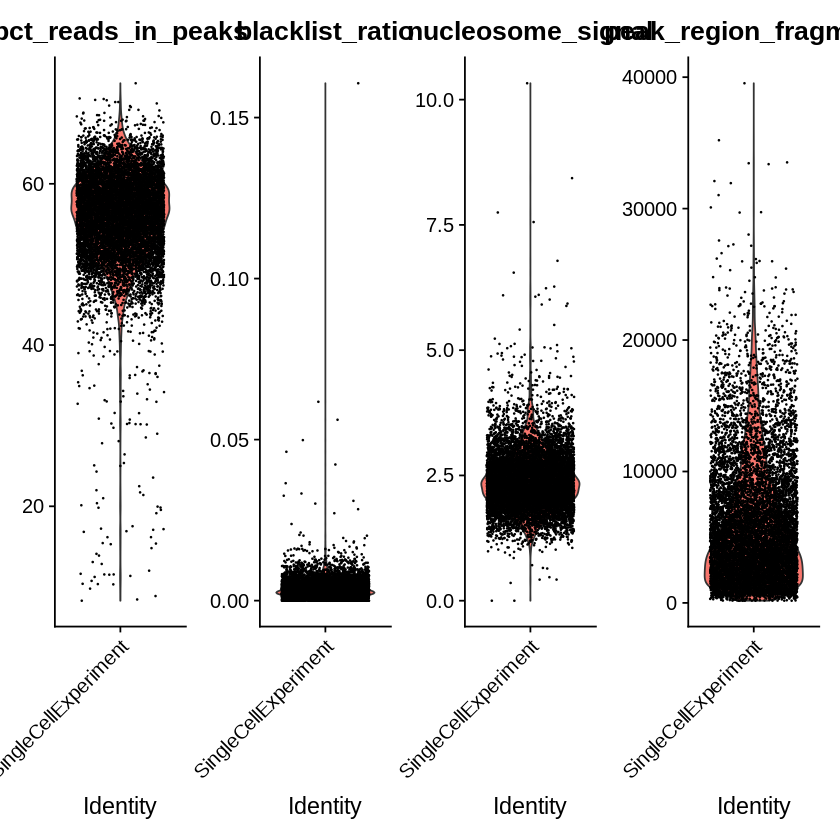

In [9]:
MPP$pct_reads_in_peaks <- MPP$nCount_peaks / MPP$passed_filters * 100
MPP$blacklist_ratio <- MPP$blacklist_region_fragments / MPP$nCount_peaks

VlnPlot(
  object = MPP,
  features = c('pct_reads_in_peaks', 'blacklist_ratio', 'nucleosome_signal', 'peak_region_fragments'),
  pt.size = 0.1,
  ncol = 4) + NoLegend()

Warning message:
"Removed 205 rows containing non-finite values (stat_bin)."Warning message:
"Removed 4 rows containing missing values (geom_bar)."

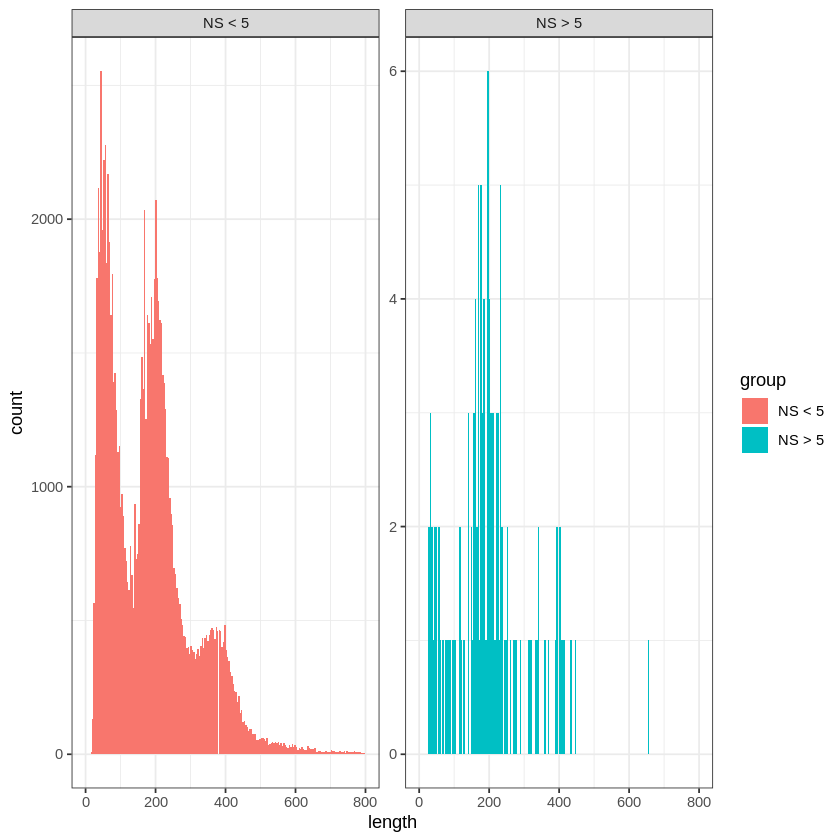

In [10]:
MPP$nucleosome_group <- ifelse(MPP$nucleosome_signal > 5, 'NS > 5', 'NS < 5')
FragmentHistogram(object = MPP, group.by = 'nucleosome_group', region = 'chr1-1-10000000')

In [11]:
# create granges object with TSS positions
gene.ranges <- genes(EnsDb.Mmusculus.v79)
gene.ranges <- gene.ranges[gene.ranges$gene_biotype == 'protein_coding', ]

tss.ranges <- GRanges(
  seqnames = seqnames(gene.ranges),
  ranges = IRanges(start = start(gene.ranges), width = 2),
  strand = strand(gene.ranges)
)

seqlevelsStyle(tss.ranges) <- 'UCSC'
tss.ranges <- keepStandardChromosomes(tss.ranges, pruning.mode = 'coarse')

# to save time use the first 2000 TSSs
MPP <- TSSEnrichment(object = MPP, tss.positions = tss.ranges[1:2000])

Finding + strand cut sites
Finding - strand cut sites
Computing mean insertion frequency in flanking regions
Normalizing TSS score


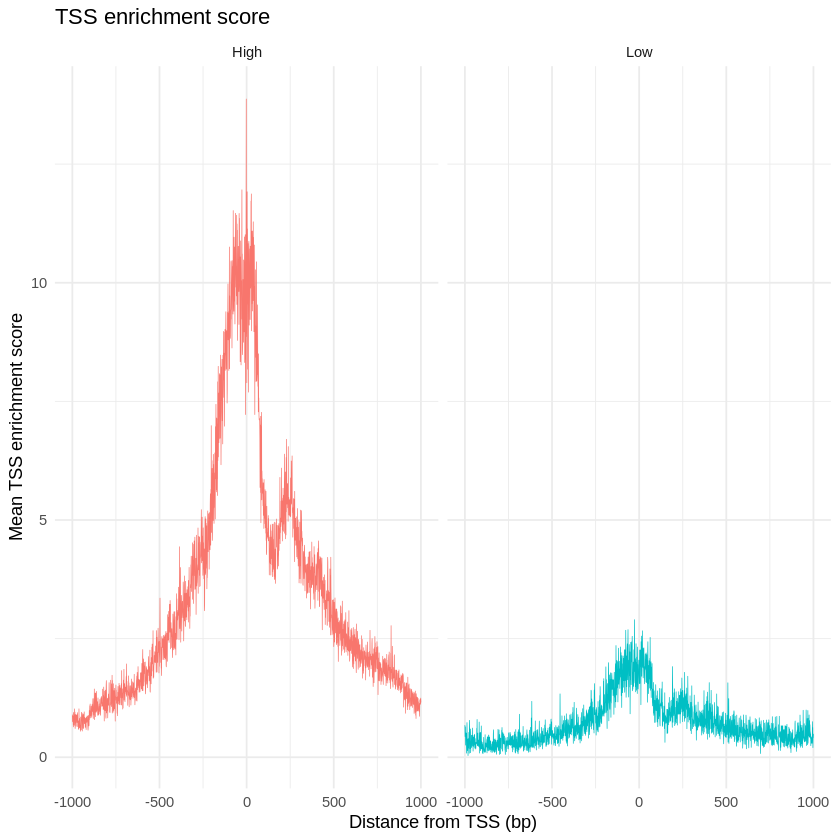

In [12]:
MPP$high.tss <- ifelse(MPP$TSS.enrichment > 2, 'High', 'Low')
TSSPlot(MPP, group.by = 'high.tss') + ggtitle("TSS enrichment score") + NoLegend()

In [13]:
MPP <- subset(MPP, 
             subset = peak_region_fragments > 1000 & 
             peak_region_fragments < 20000 & 
             pct_reads_in_peaks > 30 & 
             blacklist_ratio < 0.02 & 
             nucleosome_signal < 5 & 
             TSS.enrichment > 2)
MPP

An object of class Seurat 
327804 features across 8789 samples within 2 assays 
Active assay: peaks (163902 features, 0 variable features)
 1 other assay present: RNA

In [14]:
# save the csv with IDs of filtered cells

filtered <- rownames(MPP@meta.data)

write.csv(filtered,'./write/scATAC_MPP_filtered_cells.csv')

In [15]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.2 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.7.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] SingleCellExperiment_1.8.0  diffloop_1.14.0            
 [3] SummarizedExperiment_1.16.0 DelayedArray_0.12.0        
 [5] BiocParallel_1.20.0         matrixStats_0.56.0         
 [7] data.table_1.13.1           forcats_0.4.0              
 [9] stringr_1.4.0               dplyr_1.0.2             